<a href="https://colab.research.google.com/github/bimarshak7/learnTensorFlow/blob/main/TransferLearning_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with TensorFlow Part 1: Feature Extraction

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-11-12 16:53:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 142.250.1.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   164MB/s    in 1.0s    

2022-11-12 16:53:05 (164 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [4]:
import os
print("Images of each category in train directory")
for root, dirs, files in os.walk(train_dir):
  print(f"There are {len(files)} images in '{root}'.")

print("\nImages of each category in test directory")
for root, dirs, files in os.walk(test_dir):
  print(f"There are {len(files)} images in '{root}'.")

Images of each category in train directory
There are 0 images in '10_food_classes_10_percent/train'.
There are 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 75 images in '10_food_classes_10_percent/train/steak'.
There are 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 75 images in '10_food_classes_10_percent/train/sushi'.
There are 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 75 images in '10_food_classes_10_percent/train/ramen'.
There are 75 images in '10_food_classes_10_percent/train/pizza'.
There are 75 images in '10_food_classes_10_percent/train/grilled_salmon'.

Images of each category in test directory
There are 0 images in '10_food_classes_10_percent/test'.
There are 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 250 images in '10_food_classes_1

In [5]:
#get array of labels
import pathlib

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [6]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
num_classes = len(class_names)

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=77,
  label_mode = 'categorical',
  shuffle=True,
  image_size=IMAGE_SHAPE,
  batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=77,
  shuffle=True,
  label_mode = 'categorical',
 image_size=IMAGE_SHAPE,
  batch_size=BATCH_SIZE)

Found 2500 files belonging to 10 classes.


In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))


In [10]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

### Creating models using TensorFlow Hub

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [12]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [16]:
def create_model(model_url, num_classes=10):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

In [18]:
# Create model
resnet_model = create_model(resnet_url, num_classes=len(class_names))

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [19]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
# Fit the model
resnet_history = resnet_model.fit(train_ds,
                                  epochs=5,
                                  steps_per_epoch=len(train_ds),
                                  validation_data=val_ds,
                                  validation_steps=len(val_ds),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221112-171411
Epoch 1/5
24/24 [==============================] - 25s 580ms/step - loss: 1.9305 - accuracy: 0.3547 - val_loss: 1.1422 - val_accuracy: 0.6492
Epoch 2/5
24/24 [==============================] - 13s 529ms/step - loss: 0.8836 - accuracy: 0.7333 - val_loss: 0.8237 - val_accuracy: 0.7376
Epoch 3/5
24/24 [==============================] - 10s 422ms/step - loss: 0.6161 - accuracy: 0.8173 - val_loss: 0.7276 - val_accuracy: 0.7684
Epoch 4/5
24/24 [==============================] - 23s 978ms/step - loss: 0.4621 - accuracy: 0.8707 - val_loss: 0.6742 - val_accuracy: 0.7812
Epoch 5/5
24/24 [==============================] - 9s 381ms/step - loss: 0.3752 - accuracy: 0.9120 - val_loss: 0.6581 - val_accuracy: 0.7836


In [24]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

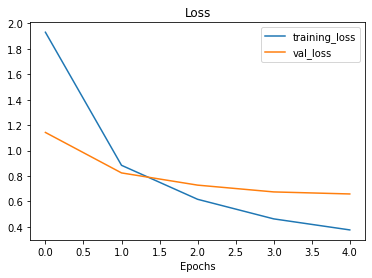

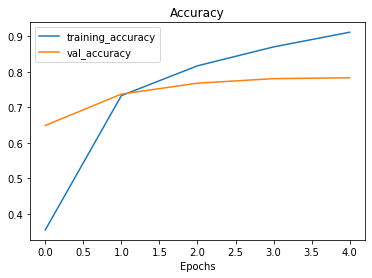

In [25]:
plot_loss_curves(resnet_history)

In [27]:
#transfer learning using efficientnet model
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=len(class_names))

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_ds, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_ds),
                                              validation_data=val_ds,
                                              validation_steps=len(val_ds),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20221112-171754
Epoch 1/5
24/24 [==============================] - 24s 564ms/step - loss: 1.8346 - accuracy: 0.4507 - val_loss: 1.2771 - val_accuracy: 0.7496
Epoch 2/5
24/24 [==============================] - 12s 513ms/step - loss: 1.0497 - accuracy: 0.7920 - val_loss: 0.8521 - val_accuracy: 0.8172
Epoch 3/5
24/24 [==============================] - 12s 513ms/step - loss: 0.7499 - accuracy: 0.8360 - val_loss: 0.6870 - val_accuracy: 0.8448
Epoch 4/5
24/24 [==============================] - 13s 553ms/step - loss: 0.6036 - accuracy: 0.8627 - val_loss: 0.6044 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 8s 326ms/step - loss: 0.5113 - accuracy: 0.8907 - val_loss: 0.5532 - val_accuracy: 0.8604


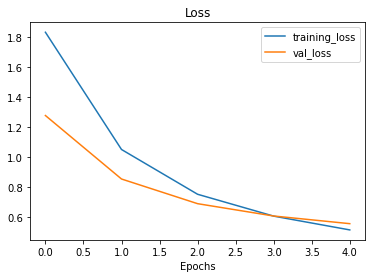

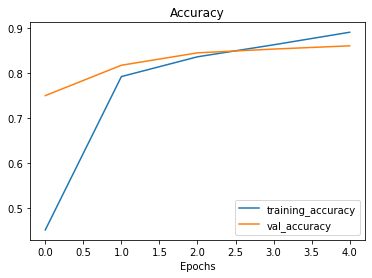

In [28]:
plot_loss_curves(efficientnet_history)